In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare the data

In [2]:
coarse_factors = [128,64,32,16]
Directory = f"data"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

### Split train test ds

In [3]:
times = [i for i in range(1,63)]
perm = np.random.permutation(times)
train_times = perm[:int(0.8*len(times))]
test_times = perm[int(0.8*len(times)):]

In [5]:
model_number = 10

df_timetrain = pd.DataFrame([train_times]).T
df_timetrain.columns = ['train']
df_timetrain.to_csv(f'data/test_train_times/times_train_{model_number}.csv') 

df_timetest = pd.DataFrame([test_times]).T
df_timetest.columns = ['test']
df_timetest.to_csv(f'data/test_train_times/times_test_{model_number}.csv')

In [6]:
#init train ds
path_data = Directory+f'/L_128/input_ds_for_simple_nn_T{train_times[0]}_L_128.nc'
nc_init = nc.Dataset(path_data)
train_ds = nc_init['sample'][:].filled()

for L in coarse_factors :
    for t in train_times :
        if L == 128 and t == train_times[0] :
            continue
        path_data = Directory+f'/L_{L}/input_ds_for_simple_nn_T{t}_L_{L}.nc'
        nc_init = nc.Dataset(path_data)
        time_ds = nc_init['sample'][:].filled()
        train_ds = np.concatenate((train_ds, time_ds), axis=0)

In [8]:
#init test ds
path_data = Directory+f'/L_128/input_ds_for_simple_nn_T{test_times[0]}_L_128.nc'
nc_init = nc.Dataset(path_data)
test_ds = nc_init['sample'][:].filled()

for L in coarse_factors :
    for t in test_times:
        if L == 128 and t == test_times[0] :
            continue
        path_data = Directory+f'/L_{L}/input_ds_for_simple_nn_T{t}_L_{L}.nc'
        nc_init = nc.Dataset(path_data)
        time_ds = nc_init['sample'][:].filled()
        test_ds = np.concatenate((test_ds, time_ds), axis=0)

In [9]:
# split train and test ds in input-output datasets
input_train, output_train, input_val, output_val = train_ds[:,:len_in], train_ds[:,len_in:], test_ds[:,:len_in], test_ds[:,len_in:]
input_train.shape

(66640, 2256)

## Define the model

In [10]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=1024, hidden_size2=512, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

In [14]:
learning_rate = 0.00001
batch_size = 32
nb_epochs = 50
train_losses=[]
test_losses=[]
n_batches = input_train.shape[0]//batch_size

In [15]:
model = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train : convert numpy array to torch tensor
input = torch.from_numpy(input_train).float()
output = torch.from_numpy(output_train).float()

# test : convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()

## Train and test the model

In [34]:
# train the model
#model.train()

for epoch in trange(nb_epochs, leave=False):
    model.train()
    tot_losses=0
    indexes_arr = np.random.permutation(input_train.shape[0]).reshape(-1, batch_size)
    for i_batch in indexes_arr:
        input_batch = input[i_batch,:]
        output_batch = output[i_batch,:]
        optimizer.zero_grad()
        # forward pass
        output_pred = model(input_batch)
        # compute loss
        loss = F.mse_loss(output_pred, output_batch, reduction='sum')
        tot_losses += loss.item()
        # backward pass
        loss.backward()
        optimizer.step()
    train_losses.append(tot_losses/n_batches)
    
    model.eval()
    # prediction
    output_pred = model(input_test)
    # compute loss
    test_loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)
    test_losses.append(test_loss.item())
    
    if (epoch+1)%5==0 or epoch==0:
        print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch+1, nb_epochs, tot_losses/n_batches))

  2%|▏         | 1/50 [00:05<04:23,  5.38s/it]

Epoch [1/50], Loss: 16.409651


 10%|█         | 5/50 [00:26<03:57,  5.27s/it]

Epoch [5/50], Loss: 3.072684


 20%|██        | 10/50 [00:53<03:29,  5.23s/it]

Epoch [10/50], Loss: 1.147509


 30%|███       | 15/50 [01:19<03:03,  5.25s/it]

Epoch [15/50], Loss: 0.631773


 40%|████      | 20/50 [01:45<02:39,  5.31s/it]

Epoch [20/50], Loss: 0.355442


 50%|█████     | 25/50 [02:12<02:13,  5.34s/it]

Epoch [25/50], Loss: 0.228185


 60%|██████    | 30/50 [02:39<01:47,  5.37s/it]

Epoch [30/50], Loss: 0.178612


 70%|███████   | 35/50 [03:06<01:20,  5.39s/it]

Epoch [35/50], Loss: 0.160858


 80%|████████  | 40/50 [03:33<00:53,  5.40s/it]

Epoch [40/50], Loss: 0.150798


 90%|█████████ | 45/50 [04:00<00:27,  5.44s/it]

Epoch [45/50], Loss: 0.143204


Epoch [50/50], Loss: 0.136255


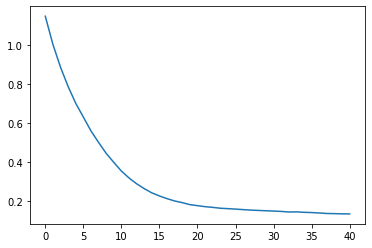

In [35]:
plt.plot(train_losses[10:])

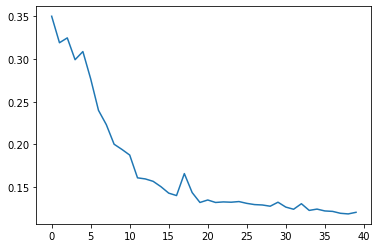

In [38]:
plt.plot(test_losses[10:])

In [39]:
# test the model

# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()

model.eval()
# prediction
output_pred = model(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)

print('Test loss: {:.6f}'.format(loss))

Test loss: 0.120173


In [40]:
torch.save(model.state_dict(), 'explo/simple_dnn')

## Compare learning rates

In [17]:
learning_rates = [2*1e-5]
batch_size = 16
nb_epochs = [1000]
train_losses=[]
test_losses=[]
models=[]
n_batches = input_train.shape[0]//batch_size

for i in range(len(learning_rates)):
    model = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[i])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99, last_epoch= -1)
    models.append(model)
    train_losses_i = []
    test_losses_i = []
    for epoch in trange(nb_epochs[i], leave=False):
        model.train()
        tot_losses=0
        indexes_arr = np.random.permutation(input_train.shape[0]).reshape(-1, batch_size)
        for i_batch in indexes_arr:
            input_batch = input[i_batch,:]
            output_batch = output[i_batch,:]
            optimizer.zero_grad()
            # forward pass
            output_pred = model(input_batch)
            # compute loss
            loss = F.mse_loss(output_pred, output_batch, reduction='sum')
            tot_losses += loss.item()
            # backward pass
            loss.backward()
            optimizer.step()
        train_losses_i.append(tot_losses/n_batches)
        
        model.eval()
        # prediction
        output_pred = model(input_test)
        # compute loss
        test_loss = F.mse_loss(output_pred, output_test, reduction='sum') / (input_test.shape[0]//batch_size)
        test_losses_i.append(test_loss.item())

        if epoch < 300:
            scheduler.step()

    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)
    print('Model {},Epoch [{}/{}], Loss: {:.6f}'.format(i+1,epoch+1, nb_epochs[i], tot_losses/n_batches))

  0%|          | 1/1000 [04:05<68:11:03, 245.71s/it]

KeyboardInterrupt: 

Text(0.5, 1.0, 'loss with exponential decaying loss (initial lr = 1e-05, gamma = 0.99)')

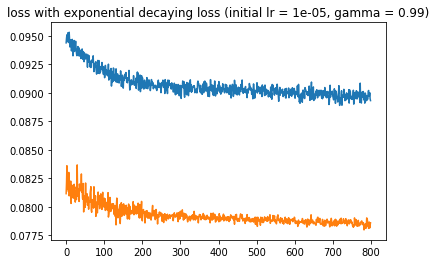

In [89]:
plt.plot(train_losses[0][200:])
plt.plot(test_losses[0][200:])
plt.title(f"loss with exponential decaying loss (initial lr = {learning_rates[0]}, gamma = 0.99)")

IndexError: list index out of range

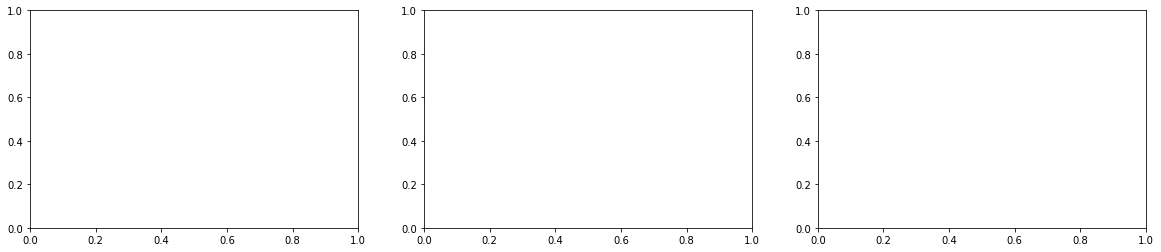

In [93]:
fig,axes = plt.subplots(1,3,figsize=(20,4))

axes[0].plot(train_losses[-3][2:])
axes[1].plot(train_losses[-2][40:])
axes[2].plot(train_losses[-1][100:])

axes[0].plot(test_losses[-3][2:])
axes[1].plot(test_losses[-2][40:])
axes[2].plot(test_losses[-1][100:])

axes[0].set_title(f"loss with learning rate = {learning_rates[0]}")
axes[1].set_title(f"loss with learning rate = {learning_rates[1]}")
axes[2].set_title(f"loss with learning rate = {learning_rates[2]}")

In [88]:
torch.save(models[0].state_dict(), 'explo/simple_dnn')